In [7]:
pip install z3-solver

In [8]:
from z3 import *
import math
import time
import itertools
import io
from datetime import datetime
import numpy as np

# this version solved 31 optimized instances. 

def pack_rectangles():

    start_time = time.time()
    s = Optimize()
    s.set("timeout", 300 * 1000)
    x = [Int(f"x_{i}") for i in range(all_rectangles)]
    y = [Int(f"y_{i}") for i in range(all_rectangles)]




    
    
    W = max_width
    H = lowerbound
    max_height = Int('max_height')

    xx=x.copy()
    yy=y.copy()    
    upperbound = H_UB (W, dimension_rectangle,xx,yy,False)

    
    s.add(max_height <= upperbound)
    s.add(max_height >= lowerbound)
    

    for i in range(number_rectangles):
        s.add(x[i] + width[i] <= max_width)
        s.add(y[i] + height[i] <= max_height)
        s.add(x[i] >= 0)
        s.add(y[i] >= 0)


    for i in range(number_rectangles):
        for j in range(i, number_rectangles):
            if i != j:
                
                s.add(Or(Or(x[i] + width[i] <= x[j], x[i] >= x[j] + width[j]),Or(y[i] + height[i] <= y[j], y[i] >= y[j] + height[j])))
    
    
    s.minimize(max_height)

    if s.check() == sat:
        print('Solved')
    else:
        print('UNSAT')
        return -1,-1,-1

    return s,x,y


def H_UB( W, rectangles,x,y, plot=False):
    placer_x = 0
    occupied_height= [0]*W
    
    q=0
    for r in rectangles:
        occupied_height_copy = occupied_height.copy()
        placer_x = np.argmin(occupied_height_copy)
        placer_y = min(occupied_height_copy)
        while ((placer_x + r[0])>W or any([x > placer_y for x in occupied_height[placer_x:(placer_x + r[0])]])):
            occupied_height_copy.remove(placer_y)
            placer_x = np.argmin(occupied_height_copy)
            placer_y = min(occupied_height_copy)

       
        x[q] = placer_x
        y[q] = placer_y
        
        for i in range(placer_x, placer_x + r[0]):
            occupied_height[i] = placer_y + r[1]
        
        q=q+1
        placer_x += r[0]
        
    
    if plot:
        plot_rectangles(rectangles, title = self.name)
        
    list_a=[]
    Z=0
    for r in rectangles:
        list_a.append(r[1]+y[Z])
        Z=Z+1
        
    return max(list_a)

for i in range(1,41):
    file_name = "./../instances/ins-" + str(i) + ".txt"
    file = open(file_name)
    max_width = int(file.readline())
    number_rectangles = int(file.readline())

    width = []
    height = []

    for line in file:
        width_height = line.split()
        width_height = [int(x) for x in width_height]
        width.append(width_height[0])
        height.append(width_height[1])

    dimension_rectangle = []
    for j, k in zip(width, height):
        dimension_rectangle.append([j, k])

    area = sum([b[0] * b[1] for b in dimension_rectangle])
    lowerbound = area / max_width

    start = time.time()
    s, px, py = pack_rectangles()
    end = time.time()

    if s != -1:
        m = s.model()
        file_out = "./../out/out-" + str(i) + ".txt"

        with open(file_out, 'w') as file:

            result = sorted([(d, m[d]) for d in m], key=lambda x: str(x[0]))
            file.write(str(max_width) + ' ' + str(lowerbound) + "\n")
            file.write(str(number_rectangles)+'\n')
            for k in range(1,number_rectangles+1):
                file.write(str(width[k-1]) + ' ' + str(height[k-1]) + ' ' + str(m.evaluate(px[k-1])) + ' ' + str(m.evaluate(py[k-1])) + "\n")



Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
UNSAT
Solved
Solved
UNSAT
Solved
Solved
Solved
Solved
UNSAT
Solved
UNSAT
Solved
UNSAT
Solved
Solved
UNSAT
UNSAT
UNSAT
UNSAT


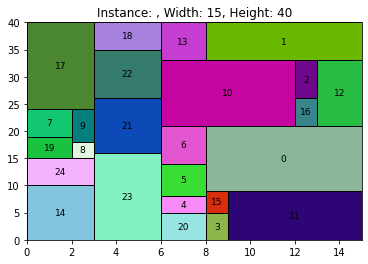

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
import numpy as np


class Rectangle:
  '''
  Implementation of a Rectangle structure

  x: the x coordinate of the LEFT BOTTOM corner
  y: the y coordinate of the LEFT BOTTOM corner
  width: the width of the rectangles
  height: the weight of the rectangles 
  '''
  def __init__ (self, width, height, x=None, y=None):
    self.x = x
    self.y = y
    self.width = width
    self.height = height

def plot_rectangles(rectangles, title="", indexes=True):
  '''
  This function plots the given input rectangles and computes the placing margins of those
  
  rectangles: the rectangles to be plotted
  title: the title to be assigned to the plot
  indexes: True to plot the indexes of the input rectangles, ordered by list index
'''

  title = re.split("/", title)
  title = title[-1].replace(".txt","")

  fig, ax = plt.subplots()

  max_height = max([rectangles[i].y + rectangles[i].height] for i in range(len(rectangles)))[0]
  max_width = max([rectangles[i].x + rectangles[i].width] for i in range(len(rectangles)))[0]

  for i in range(0,len(rectangles)):
    np.random.seed(i)
    rect_draw = patches.Rectangle( (rectangles[i].x, rectangles[i].y) , rectangles[i].width , rectangles[i].height, facecolor = np.random.rand(3,), edgecolor='k', label="ciao")
    ax.add_patch(rect_draw)

    if indexes:
      cx = rectangles[i].x + rectangles[i].width/2.0
      cy = rectangles[i].y + rectangles[i].height/2.0
      ax.annotate(i, (cx, cy), color='k', 
                  fontsize=9, ha='center', va='center')

  ax.set_title("Instance: {}, Width: {}, Height: {}".format(title, max_width, max_height))
  ax.spines['top'].set_visible(False)
  ax.set_xlim((0, max_width))
  ax.set_ylim((0, max_height))
  #ax.set_aspect('equal')
  ax.autoscale_view(tight=True)
  ax.set_axisbelow(True)
  ax.grid()
  plt.show()



list =[]

#ploting instance number 36 as an example 
instance=36
file_name = "./../out/out-" + str(instance) + ".txt"
file_out = open(file_name)
results= file_out.readlines()



for coordinates in results[2:]:
    w_h_x_y = coordinates.split()
    w_h_x_y = [int(x) for x in w_h_x_y]
    w= w_h_x_y[0]
    h= w_h_x_y[1]
    x= w_h_x_y[2]
    y= w_h_x_y[3]
    list.append(Rectangle (w,h,x,y))
    
plot_rectangles(list)